# Capstone Project Klasifikasi Gambar Mata Terbuka atau Mata Tertutup
- **Nama:** WatchIn
- **Group ID:** CC25-CF019

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tarqhs","key":"cbe702f0bf5cc71fe305081bcccccf6b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#!/bin/bash
!kaggle datasets download -d serenaraju/yawn-eye-dataset-new

Dataset URL: https://www.kaggle.com/datasets/serenaraju/yawn-eye-dataset-new
License(s): unknown


In [7]:
!unzip yawn-eye-dataset-new.zip

Archive:  yawn-eye-dataset-new.zip
  inflating: dataset_new/test/Closed/_107.jpg  
  inflating: dataset_new/test/Closed/_115.jpg  
  inflating: dataset_new/test/Closed/_116.jpg  
  inflating: dataset_new/test/Closed/_120.jpg  
  inflating: dataset_new/test/Closed/_129.jpg  
  inflating: dataset_new/test/Closed/_130.jpg  
  inflating: dataset_new/test/Closed/_132.jpg  
  inflating: dataset_new/test/Closed/_137.jpg  
  inflating: dataset_new/test/Closed/_14.jpg  
  inflating: dataset_new/test/Closed/_148.jpg  
  inflating: dataset_new/test/Closed/_152.jpg  
  inflating: dataset_new/test/Closed/_159.jpg  
  inflating: dataset_new/test/Closed/_161.jpg  
  inflating: dataset_new/test/Closed/_163.jpg  
  inflating: dataset_new/test/Closed/_164.jpg  
  inflating: dataset_new/test/Closed/_167.jpg  
  inflating: dataset_new/test/Closed/_168.jpg  
  inflating: dataset_new/test/Closed/_169.jpg  
  inflating: dataset_new/test/Closed/_172.jpg  
  inflating: dataset_new/test/Closed/_181.jpg  
  infl

In [8]:
# Lokasi dataset asli dan target baru
source_dir = 'dataset_new'
target_dir = 'dataset_combined'

# Buat struktur folder baru
for phase in ['train', 'test']:
    os.makedirs(os.path.join(target_dir, phase, 'closed'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, phase, 'opened'), exist_ok=True)

    # Gabungkan Closed dan yawn ke closed folder
    for cls in ['Closed', 'yawn']:
        src_path = os.path.join(source_dir, phase, cls)
        dst_path = os.path.join(target_dir, phase, 'closed')
        for file in os.listdir(src_path):
            shutil.copy(os.path.join(src_path, file), os.path.join(dst_path, file))

    # Gabungkan Open dan no_yawn ke opened
    for cls in ['Open', 'no_yawn']:
        src_path = os.path.join(source_dir, phase, cls)
        dst_path = os.path.join(target_dir, phase, 'opened')
        for file in os.listdir(src_path):
            shutil.copy(os.path.join(src_path, file), os.path.join(dst_path, file))

print("Penggabungan selesai. Data disimpan ke folder 'dataset_combined'")

Penggabungan selesai. Data disimpan ke folder 'dataset_combined'


In [9]:
def load_images(directory):
    images = []
    labels = []

    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        for filename in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
            image_path = os.path.join(category_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(category)

    images = np.array(images, dtype='float32')
    return images, labels

In [10]:
data_dir = 'dataset_combined/train/'
X, y = load_images(data_dir)

Loading closed: 100%|██████████| 1234/1234 [00:03<00:00, 343.94it/s]


In [11]:
data_dir_test = 'dataset_combined/test/'
X_test, y_test = load_images(data_dir_test)

Loading closed: 100%|██████████| 215/215 [00:00<00:00, 543.09it/s]


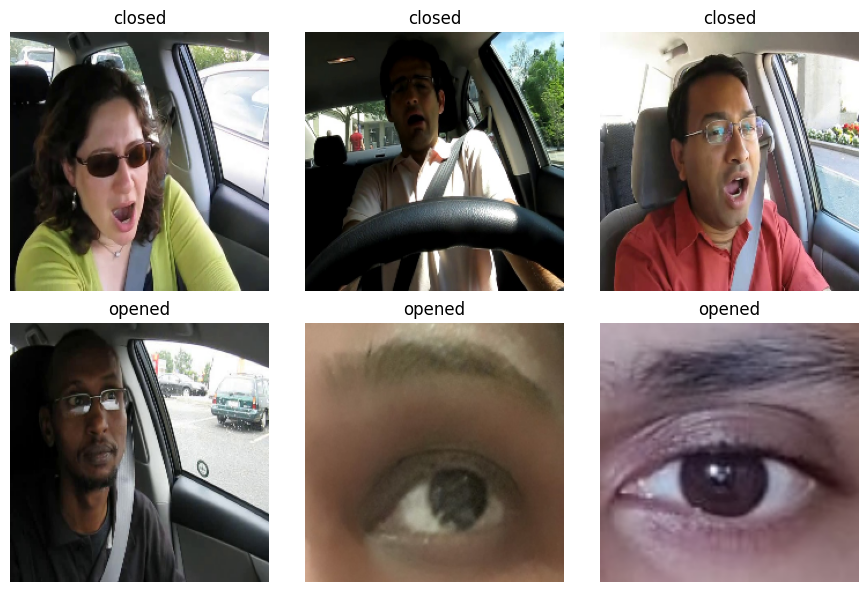

In [12]:
def tampilkan_contoh_gambar_tertentu(images, labels, kelas_unik, jumlah_per_kelas=3):
    plt.figure(figsize=(jumlah_per_kelas * 3, len(kelas_unik) * 3))

    for idx, kelas in enumerate(kelas_unik):
        indeks_kelas = [i for i, label in enumerate(labels) if label == kelas]

        contoh_indeks = [
            indeks_kelas[0],
            indeks_kelas[len(indeks_kelas) // 2],
            indeks_kelas[-1]
        ]

        for j, indeks in enumerate(contoh_indeks):
            i = idx * jumlah_per_kelas + j
            plt.subplot(len(kelas_unik), jumlah_per_kelas, i + 1)
            plt.imshow(images[indeks].astype('uint8'))
            plt.title(f"{kelas}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

kelas_unik = sorted(set(y))
tampilkan_contoh_gambar_tertentu(X, y, kelas_unik, jumlah_per_kelas=3)

In [13]:
distribusi = pd.Series(y).value_counts()

print("Distribusi jumlah gambar per kelas:")
print(distribusi)

Distribusi jumlah gambar per kelas:
closed    1234
opened    1233
Name: count, dtype: int64


### Split Dataset

In [14]:
X = X / 255.0

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [15]:
X_test = X_test / 255.0

encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## Modelling

In [17]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units=1,activation='sigmoid'))

warnings.filterwarnings('ignore')

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,401 (9.38 MB)

 Trainable params: 2,457,697 (9.38 MB)

 Non-trainable params: 704 (2.75 KB)

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
early_stop = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)

history = model.fit(x=X_train,
            y=y_train,
            epochs=30,
            batch_size=32,
            validation_data=(X_val,y_val),
            callbacks=[early_stop,reduce_lr])

warnings.filterwarnings('ignore')

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.7054 - loss: 0.6969 - val_accuracy: 0.5061 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8323 - loss: 0.3416 - val_accuracy: 0.5020 - val_loss: 1.9269 - learning_rate: 0.0010
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8567 - loss: 0.3087 - val_accuracy: 0.5425 - val_loss: 0.7447 - learning_rate: 0.0010
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8937 - loss: 0.2488 - val_accuracy: 0.7247 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9046 - loss: 0.2245 - val_accuracy: 0.7085 - val_loss: 0.5258 - learning_rate: 0.0010
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9373 - loss: 0.1622 - val_accuracy: 0.7773 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9434 - loss: 0.1398 - val_a

## Evaluasi dan Visualisasi

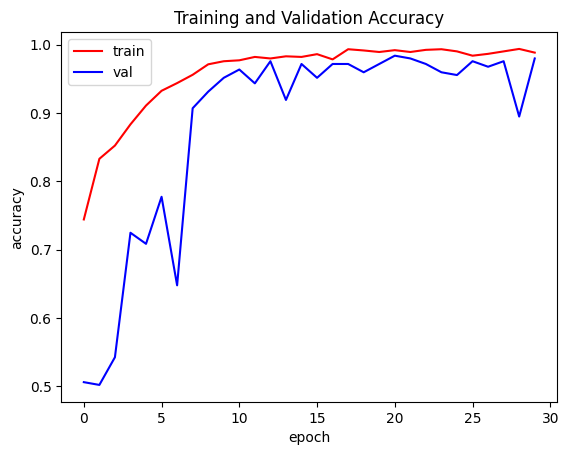

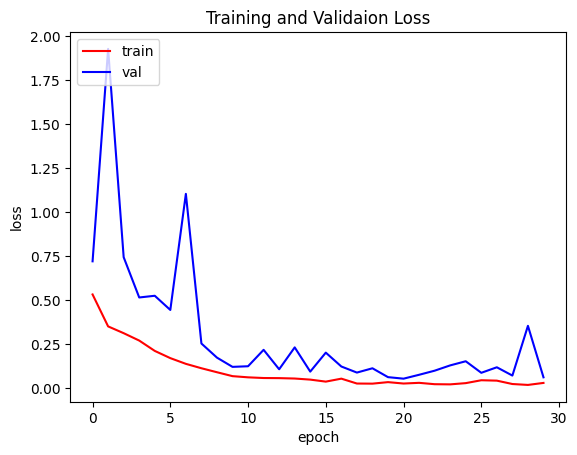

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [22]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f"Akurasi Train: {train_acc:.4f}")
print(f"Akurasi Validation: {val_acc:.4f}")

Akurasi Train: 0.9982
Akurasi Validation: 0.9838


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9885


## Konversi Model

In [24]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [25]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/model_tfjs

2025-05-10 15:17:31.061537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746890251.080934    3755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746890251.088276    3755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-10 15:17:35.450261: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746890255.450442    3755 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [27]:
!zip -r saved_model.zip /content/saved_model/

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 69%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)


In [26]:
!zip -r /content/model_tfjs.zip /content/model_tfjs/

  adding: content/model_tfjs/ (stored 0%)
  adding: content/model_tfjs/model.json (deflated 91%)
  adding: content/model_tfjs/group1-shard3of3.bin (deflated 7%)
  adding: content/model_tfjs/group1-shard2of3.bin (deflated 7%)
  adding: content/model_tfjs/group1-shard1of3.bin (deflated 7%)


## Inference

In [32]:
# Memuat model dari folder SavedModel
loaded_model = tf.saved_model.load('/content/saved_model')
print("Model berhasil dimuat!")

Model berhasil dimuat!


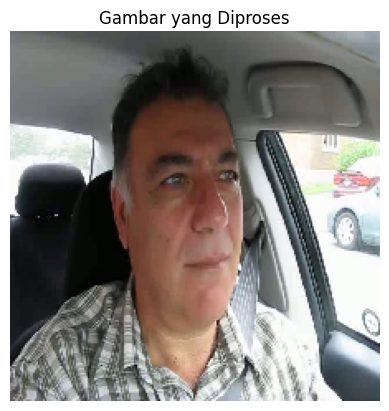

Data siap untuk inference!


In [34]:
# Mengunggah gambar (misalnya 'image.jpg')
img = image.load_img('/content/Opened-1.jpg', target_size=(224, 224))

# Preprocessing gambar menjadi array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi batch
img_array /= 255.0  # Normalisasi jika diperlukan

# Menampilkan gambar
plt.imshow(img_array[0])  # Mengakses elemen pertama dari batch
plt.title("Gambar yang Diproses")
plt.axis("off")  # Menghilangkan sumbu
plt.show()

print("Data siap untuk inference!")


In [35]:
# Daftar label kelas (urutannya harus sesuai dengan saat pelatihan model)
class_names = ['Opened', 'Closed']

# Melakukan inference
predictions = model.predict(img_array)

# Menampilkan hasil prediksi (probabilitas)
print("Hasil prediksi:", predictions)

# Mengambil indeks kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions, axis=1)[0]

# Mengonversi indeks menjadi nama kelas
predicted_class_name = class_names[predicted_class]

# Menampilkan nama kelas
print("Kelas prediksi:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
Hasil prediksi: [[0.99944824]]
Kelas prediksi: Opened
